In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

### Determining the financially optimal rotation age

In [3]:
conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT econsummary.*, cases.mgmtid, CAST (cases.standid AS INT) AS siteindex
FROM econsummary, cases
WHERE econsummary.caseid = cases.caseid AND cases.mgmtid = 'SHR2';
'''
short = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [4]:
short['siteclass'] = pd.cut(short.siteindex, bins=[0,75,95,115,135,161], 
                           labels=[5, 4, 3, 2, 1], right=False).astype('int')
pnv_smooth = short.groupby('caseid').rolling(window=5, on='year').mean().reset_index(drop=True)[['caseid', 'year', 'pnv']]
short = short.merge(pnv_smooth, how='left', on=['caseid', 'year'], suffixes=('','_smooth'))

In [5]:
short.columns

Index(['caseid', 'standid', 'year', 'period', 'pretend_harvest',
       'undiscounted_cost', 'undiscounted_revenue', 'discounted_cost',
       'discounted_revenue', 'pnv', 'irr', 'bc_ratio', 'rrr', 'sev',
       'value_of_forest', 'value_of_trees', 'mrch_cubic_volume',
       'mrch_boardfoot_volume', 'discount_rate', 'given_sev', 'mgmtid',
       'siteindex', 'siteclass', 'pnv_smooth'],
      dtype='object')

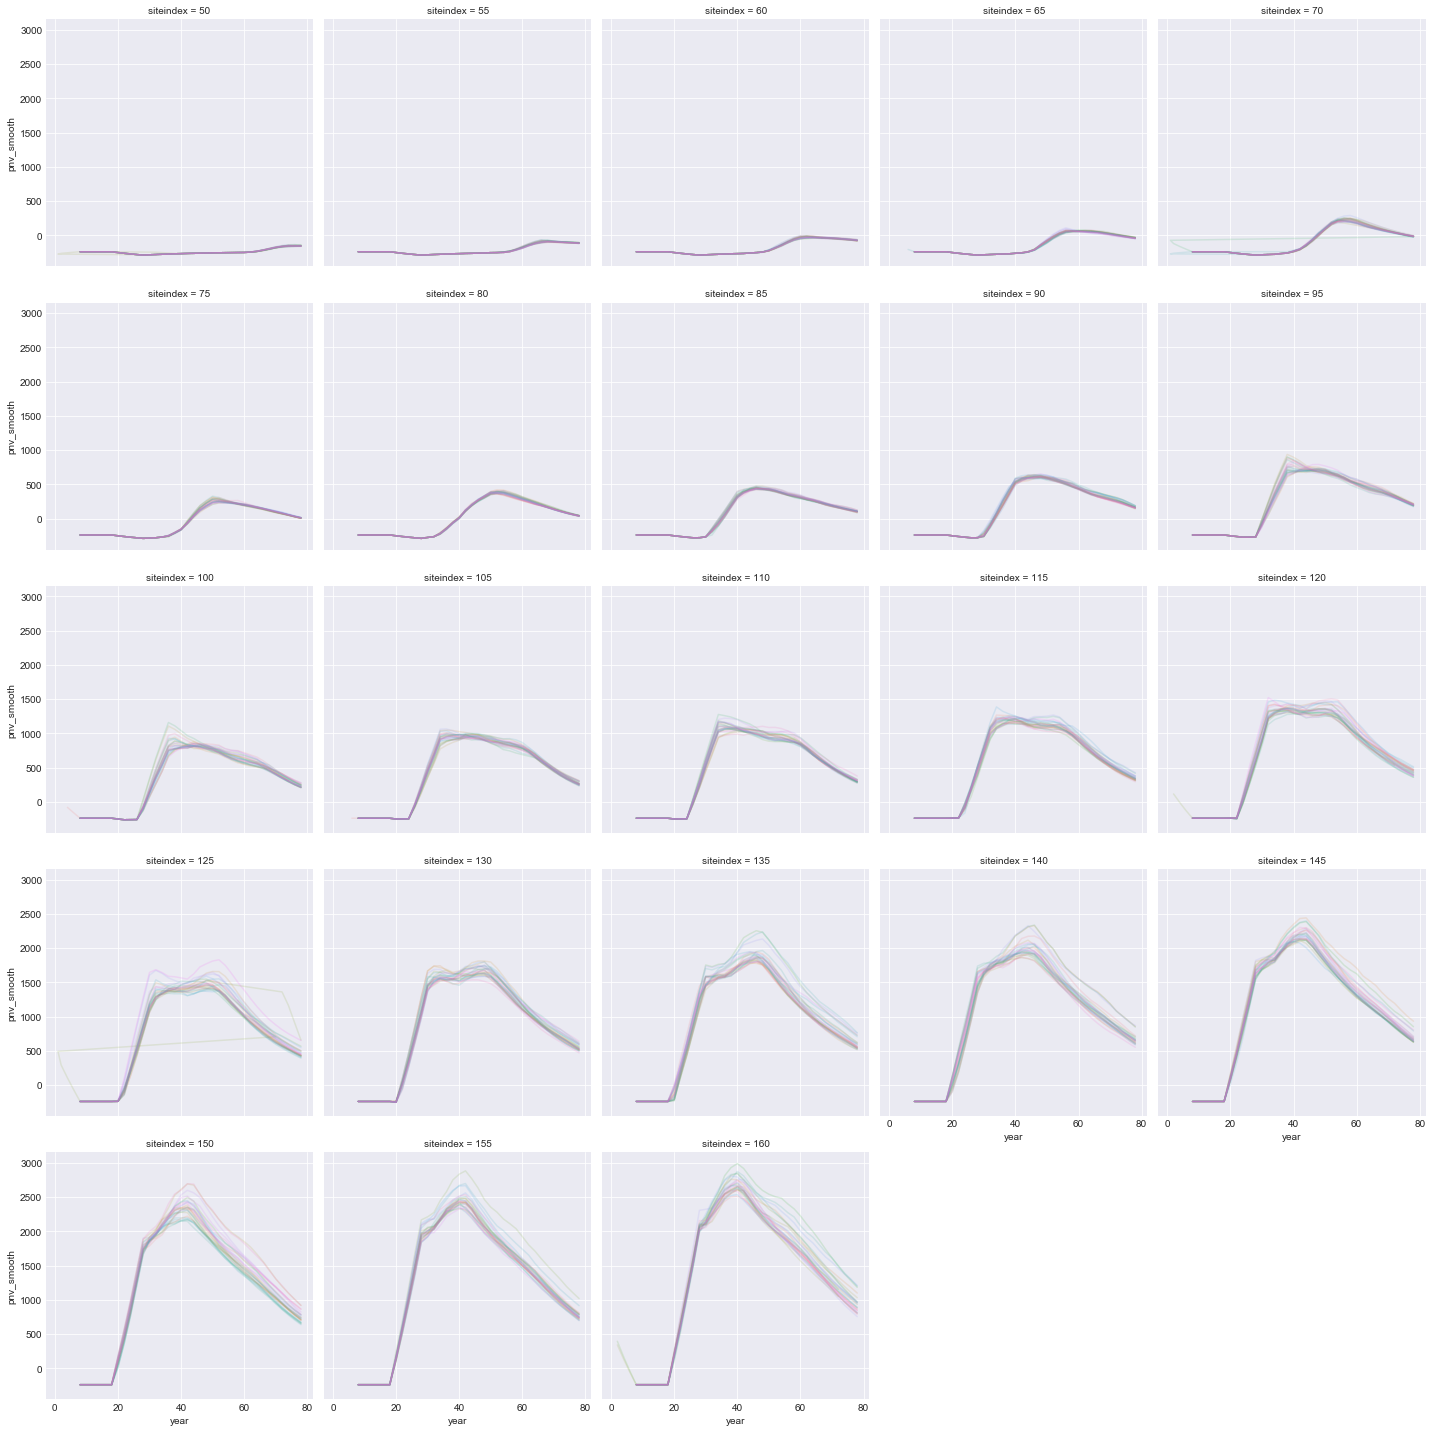

In [6]:
g = sns.FacetGrid(data=short, col='siteindex', hue='caseid', col_wrap=5, size=4, sharey=True, sharex=True)
g = g.map(plt.plot, 'year', 'pnv_smooth', alpha=0.15)

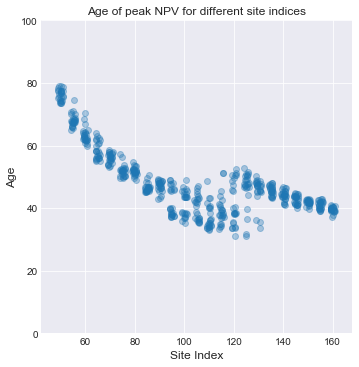

In [7]:
# FOR ALL SITE INDICES
maxes = short[['year', 'siteindex']].iloc[short.groupby(['caseid', 'siteindex'])['pnv_smooth'].idxmax()]

g = sns.lmplot(x="siteindex", y="year", data=maxes, fit_reg=False, 
               x_jitter=1, y_jitter=1, scatter_kws={'alpha':0.35})

plt.ylim(0,100)
plt.title('Age of peak NPV for different site indices')
plt.xlabel("Site Index", fontsize=12)
plt.ylabel("Age", fontsize=12);

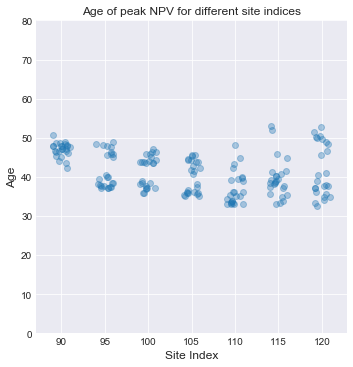

In [8]:
# FOR ONLY SITE INDICES WE'LL BE MODELING: 90-120
maxes = short[['year', 'siteindex']].iloc[short.groupby(['caseid', 'siteindex'])['pnv_smooth'].idxmax()]
maxes = maxes.loc[maxes.siteindex.between(90,120)]

g = sns.lmplot(x="siteindex", y="year", data=maxes, fit_reg=False, 
               x_jitter=1, y_jitter=1, scatter_kws={'alpha':0.35})

plt.ylim(0,80)
plt.title('Age of peak NPV for different site indices')
plt.xlabel("Site Index", fontsize=12)
plt.ylabel("Age", fontsize=12);

### Determining the biologically optimal rotation age

In [9]:
conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT summary.*, cases.mgmtid, CAST (cases.standid AS INT) AS siteindex
FROM summary, cases
WHERE summary.caseid = cases.caseid AND cases.mgmtid = 'LON2';
'''
# read the query into a pandas dataframe
long = pd.read_sql(SQL, conn)
conn.close()

In [10]:
long['siteclass'] = pd.cut(long.siteindex, bins=[0,75,95,115,135,161], 
                           labels=[5, 4, 3, 2, 1], right=False).astype('int')

long = long.sort_values(['caseid','age']).set_index(['caseid', 'age'])
long['atbdft'] = long.bdft - long.rbdft
long['attcuft'] = long.tcuft - long.rtcuft
# calculate the cumulative boardfoot volume of harvests for each simulation
long['cum_rbdft'] = long.groupby(level=0, as_index=False)['rbdft'].cumsum()
long['cum_rtcuft'] = long.groupby(level=0, as_index=False)['rtcuft'].cumsum()
# calculate the total standing plus removed volume
long['std_plus_rem_bdft'] = long.atbdft + long.cum_rbdft
long['std_plus_rem_tcuft'] = long.attcuft + long.cum_rtcuft
long = long.reset_index()

# smooth standing + removed volumes
smooth = long.groupby('caseid').rolling(window=5, on='age').mean().reset_index(drop=True)[['caseid', 'age', 'std_plus_rem_bdft', 'std_plus_rem_tcuft']]
long = long.merge(smooth, on=['caseid', 'age'], suffixes=('', '_smooth'))

# divide the total standing and removed volume by the year to get mean annual increment
long['mai_bdft'] = long.std_plus_rem_bdft_smooth / long.year
long['mai_tcuft'] = long.std_plus_rem_tcuft_smooth / long.year

# Calculate PAI
pai = long.set_index(['caseid', 'age'])[['std_plus_rem_bdft_smooth', 'std_plus_rem_tcuft_smooth']].diff().reset_index()
pai.loc[pai.age==0, ['std_plus_rem_bdft_smooth','std_plus_rem_tcuft_smooth']] = np.nan
pai[['std_plus_rem_bdft_smooth','std_plus_rem_tcuft_smooth']] = pai[['std_plus_rem_bdft_smooth','std_plus_rem_tcuft_smooth']]/5
long = long.merge(pai, on=['caseid', 'age'], suffixes=('', '_pai'))

In [11]:
long.columns

Index(['caseid', 'age', 'standid', 'year', 'tpa', 'ba', 'sdi', 'ccf', 'topht',
       'qmd', 'tcuft', 'mcuft', 'bdft', 'rtpa', 'rtcuft', 'rmcuft', 'rbdft',
       'atba', 'atsdi', 'atccf', 'attopht', 'atqmd', 'prdlen', 'acc', 'mort',
       'mai', 'fortyp', 'sizecls', 'stkcls', 'mgmtid', 'siteindex',
       'siteclass', 'atbdft', 'attcuft', 'cum_rbdft', 'cum_rtcuft',
       'std_plus_rem_bdft', 'std_plus_rem_tcuft', 'std_plus_rem_bdft_smooth',
       'std_plus_rem_tcuft_smooth', 'mai_bdft', 'mai_tcuft',
       'std_plus_rem_bdft_smooth_pai', 'std_plus_rem_tcuft_smooth_pai'],
      dtype='object')

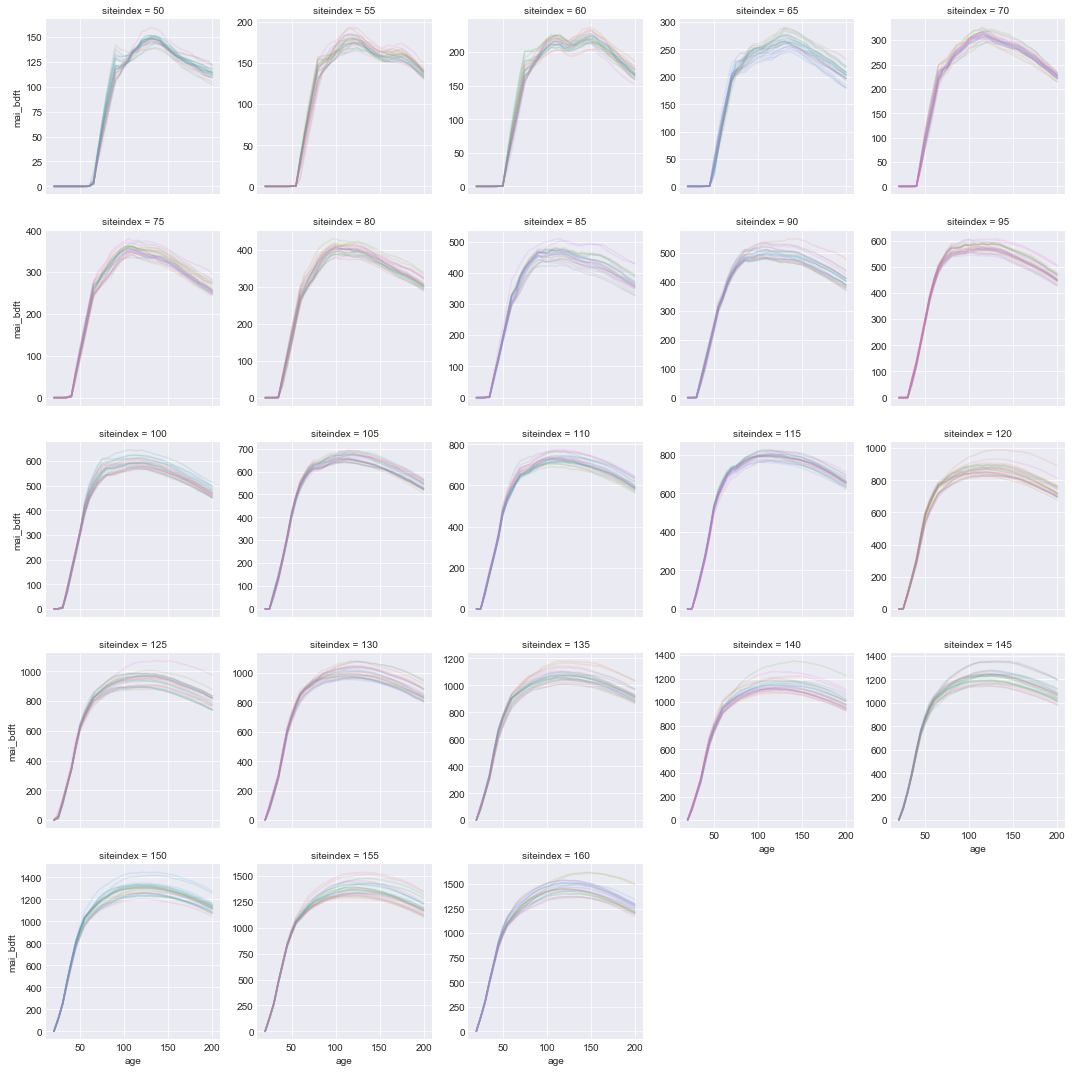

In [12]:
g = sns.FacetGrid(data=long, col='siteindex', col_wrap=5, hue='caseid', sharey=False)
g = g.map(plt.plot, 'age', 'mai_bdft', alpha=0.15)

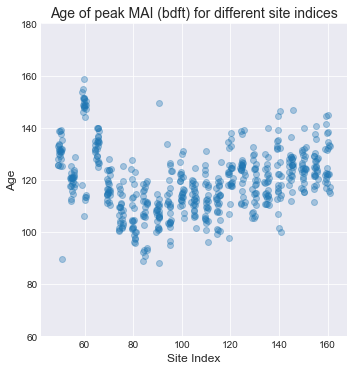

In [13]:
# FOR ALL SITE INDICES
maxes = long[['year', 'siteindex']].iloc[long.groupby(['caseid', 'siteindex'])['mai_bdft'].idxmax()]

g = sns.lmplot(x="siteindex", y="year", data=maxes, fit_reg=False, 
               x_jitter=1, y_jitter=5, scatter_kws={'alpha':0.35})

plt.ylim(60,180)
plt.title('Age of peak MAI (bdft) for different site indices', fontsize=14)
plt.xlabel("Site Index", fontsize=12)
plt.ylabel("Age", fontsize=12);

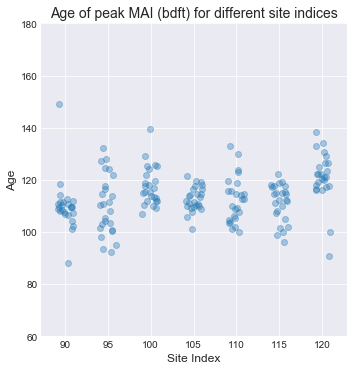

In [14]:
# FOR ONLY SITE INDICES WE'LL BE MODELING: 90-120
maxes = long[['year', 'siteindex']].iloc[long.groupby(['caseid', 'siteindex'])['mai_bdft'].idxmax()]
maxes = maxes.loc[maxes.siteindex.between(90,120)]

g = sns.lmplot(x="siteindex", y="year", data=maxes, fit_reg=False, 
               x_jitter=1, y_jitter=5, scatter_kws={'alpha':0.35})

plt.ylim(60,180)
plt.title('Age of peak MAI (bdft) for different site indices', fontsize=14)
plt.xlabel("Site Index", fontsize=12)
plt.ylabel("Age", fontsize=12);